Bibliotheken

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import chi2
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy.stats import binomtest
from scipy.stats import kstest


# Warnungen unterdrücken
warnings.filterwarnings("ignore")

Zeitreihe einlesen und anpassen

In [2]:
# CSV-Datei einlesen
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)

# Filtern nach Store 1
store1 = df[df['Store'] == 40].copy()

# Datensatz nach Datum sortieren und als Index setzen
store1.sort_values('Date', inplace=True)
store1.set_index('Date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store1['Weekly_Sales']

Zeitreihe plotten

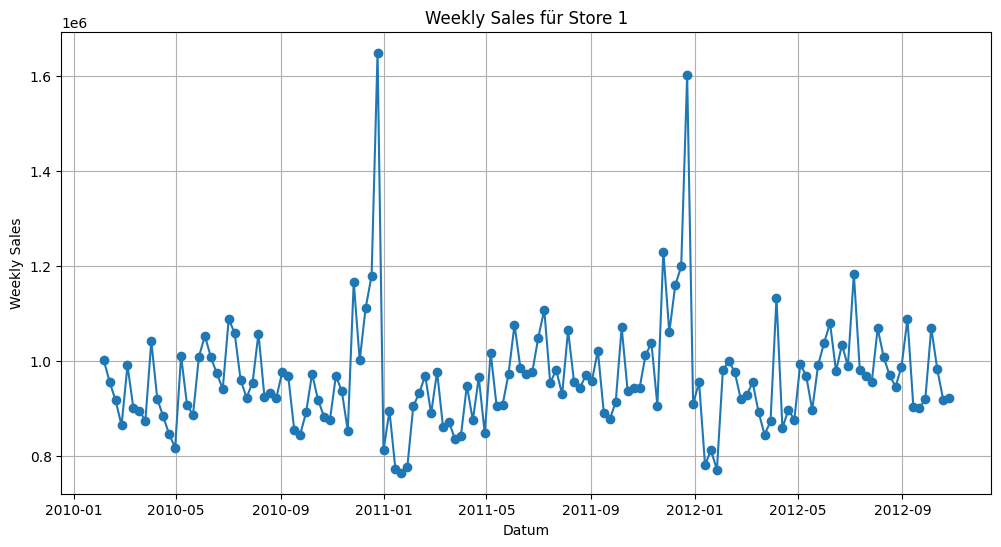

In [3]:
# Zeitreihe plotten (gesamte Daten)
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store 1')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Grid Search

In [4]:
# Grid Search zur Optimierung der ARIMA-Parameter mittels AIC
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

print("Suche nach optimalen Parametern basierend auf AIC...")
for order in pdq:
    try:
        model = ARIMA(sales, order=order)
        results = model.fit()
        print(f"ARIMA{order} - AIC:{results.aic:.2f}  BIC:{results.bic:.2f}")
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except Exception as e:
        # Fehler während der Modellanpassung überspringen
        continue

if best_order is not None:
    print(f"\nBestes Modell: ARIMA{best_order} mit AIC: {best_aic:.2f}")
else:
    print("Kein geeignetes Modell gefunden.")
    exit()

# Ausgabe der Modellzusammenfassung
print(best_model.summary())

Suche nach optimalen Parametern basierend auf AIC...
ARIMA(0, 0, 0) - AIC:4318.95  BIC:4324.88
ARIMA(0, 0, 1) - AIC:3745.11  BIC:3754.00
ARIMA(0, 0, 2) - AIC:3740.36  BIC:3752.21
ARIMA(0, 1, 0) - AIC:3776.06  BIC:3779.01
ARIMA(0, 1, 1) - AIC:3744.75  BIC:3750.66
ARIMA(0, 1, 2) - AIC:3744.56  BIC:3753.43
ARIMA(1, 0, 0) - AIC:3741.82  BIC:3750.71
ARIMA(1, 0, 1) - AIC:3742.07  BIC:3753.92
ARIMA(1, 0, 2) - AIC:3734.46  BIC:3749.28
ARIMA(1, 1, 0) - AIC:3752.65  BIC:3758.56
ARIMA(1, 1, 1) - AIC:3739.29  BIC:3748.15
ARIMA(1, 1, 2) - AIC:3747.76  BIC:3759.58
ARIMA(2, 0, 0) - AIC:3740.74  BIC:3752.59
ARIMA(2, 0, 1) - AIC:3737.98  BIC:3752.79
ARIMA(2, 0, 2) - AIC:3735.69  BIC:3753.46
ARIMA(2, 1, 0) - AIC:3752.80  BIC:3761.66
ARIMA(2, 1, 1) - AIC:3738.57  BIC:3750.39
ARIMA(2, 1, 2) - AIC:3736.43  BIC:3751.20

Bestes Modell: ARIMA(1, 0, 2) mit AIC: 3734.46
                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:       

In Sample (Residuen)

In [5]:
fitted_values = best_model.fittedvalues

residuals = sales - fitted_values

mean_resid = residuals.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")

Mittelwert der Residuen: -18.1505


Beobachtete Werte vs. fitted values (in-sample)

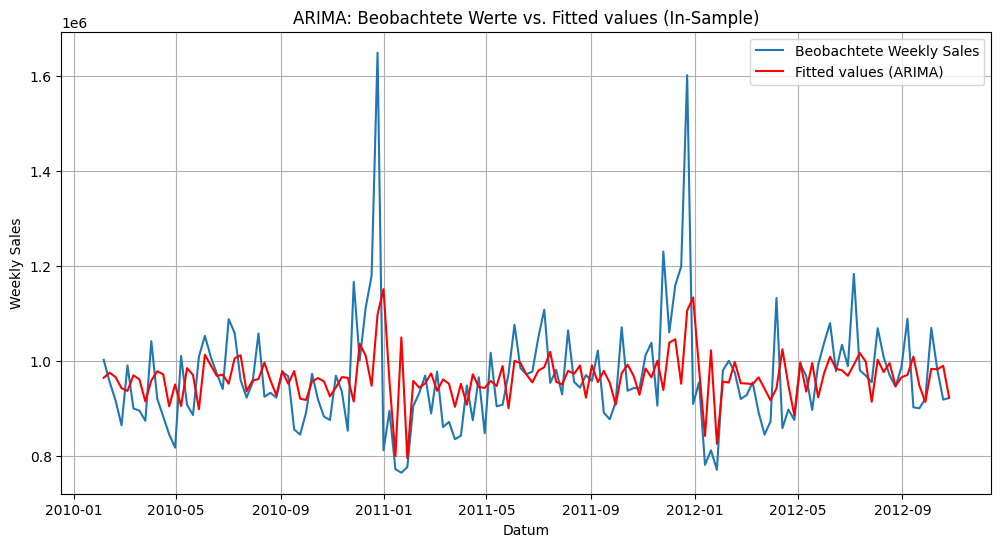

In [6]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachtete Weekly Sales')
plt.plot(fitted_values, color='red', label='Fitted values (ARIMA)')
plt.title('ARIMA: Beobachtete Werte vs. Fitted values (In-Sample)')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

Residuen als Zeitreihe

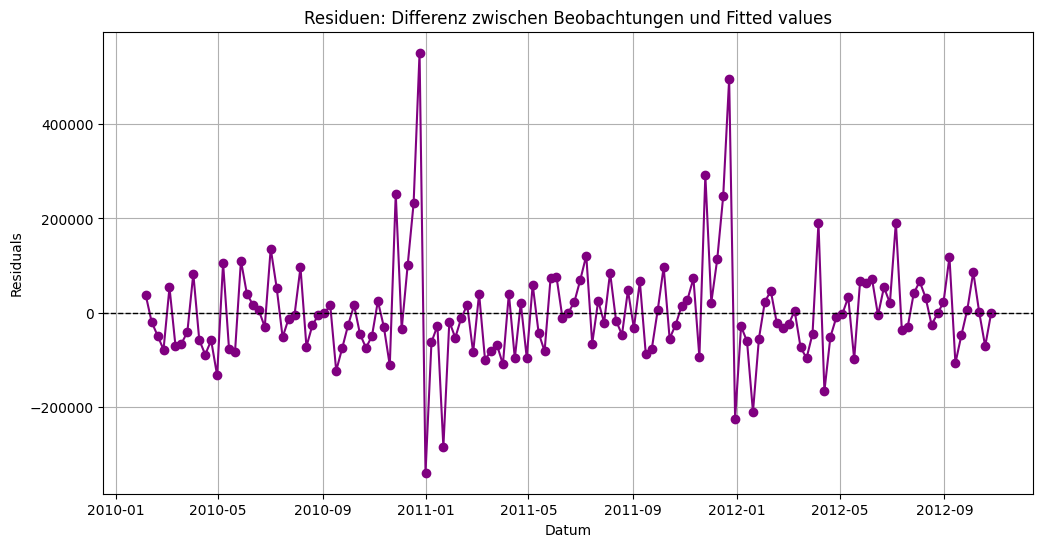

In [7]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='purple')
plt.title('Residuen: Differenz zwischen Beobachtungen und Fitted values')
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

Histogramm der Residuen

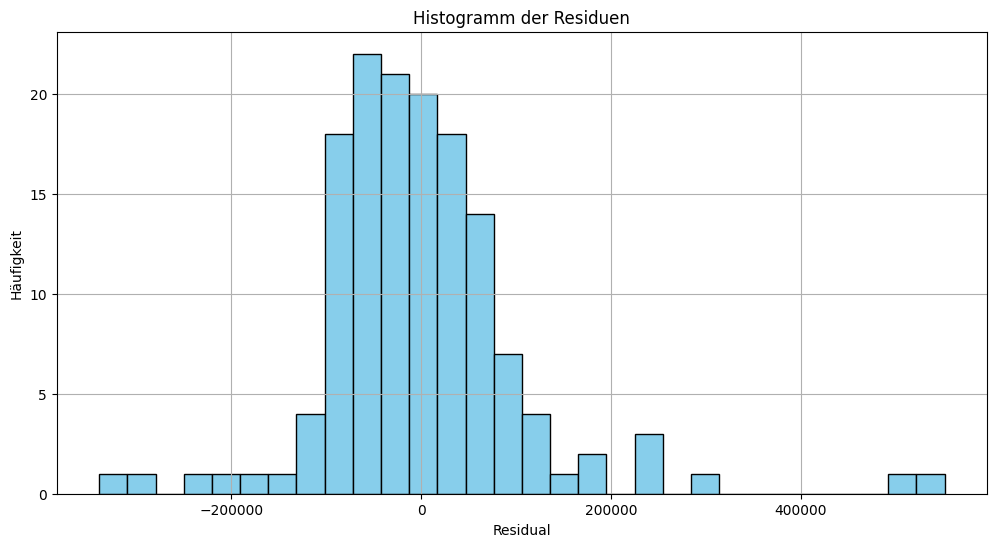

In [8]:
# Plot
resid_clean = residuals.dropna()
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der Residuen')
plt.xlabel('Residual')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

ACF

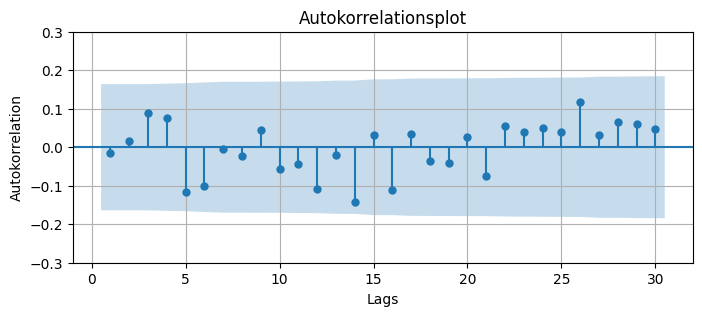

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(residuals.dropna(), lags=30, zero=False, ax=ax)
ax.set_ylim(-0.3, 0.3)
ax.set_title('Autokorrelationsplot')
ax.set_xlabel('Lags')
ax.set_ylabel('Autokorrelation')
ax.grid(True)
plt.show()

Box-Pierce

In [10]:
resid_clean = residuals.dropna()

bp_results = acorr_ljungbox(resid_clean, lags=[10], boxpierce=True, return_df=True)

bp_stat = bp_results.loc[10, 'bp_stat']
bp_pvalue = bp_results.loc[10, 'bp_pvalue']

print("Box-Pierce Test (Lag 10):")
print("Teststatistik:", bp_stat)
print("p-Wert:", bp_pvalue)

Box-Pierce Test (Lag 10):
Teststatistik: 6.265070136014515
p-Wert: 0.792523219888654


Ljung-Box

In [11]:
resid_clean = residuals.dropna()

lb_results = acorr_ljungbox(resid_clean, lags=[10], boxpierce=False, return_df=True)

lb_stat = lb_results.loc[10, 'lb_stat']
lb_pvalue = lb_results.loc[10, 'lb_pvalue']

print("Ljung-Box Test (Lag 10):")
print("Teststatistik:", lb_stat)
print("p-Wert:", lb_pvalue)

Ljung-Box Test (Lag 10):
Teststatistik: 6.59729130974957
p-Wert: 0.7628371725424609


Breusch-Godfrey

In [12]:
resid = residuals.dropna()

# Anzahl der Lags, die im Breusch-Godfrey-Test berücksichtigt werden sollen
nlags = 10

# Erstelle ein DataFrame mit den lagged residuals
lagged_data = pd.concat([resid.shift(i) for i in range(1, nlags+1)], axis=1)
lagged_data.columns = [f'lag_{i}' for i in range(1, nlags+1)]

# Entferne Zeilen mit NaN (durch die Verschiebung)
lagged_data = lagged_data.dropna()

# Passe die Residuen so an, dass sie zu den lagged Daten passen
resid_aligned = resid.loc[lagged_data.index]

# Füge eine Konstante hinzu
X = add_constant(lagged_data)

# Schätze das OLS-Modell: Residuen ~ lagged Residuen
ols_model = OLS(resid_aligned, X).fit()

# Berechne die Breusch-Godfrey Teststatistik: n * R²
bg_stat = ols_model.nobs * ols_model.rsquared

# Berechne den p-Wert aus der Chi-Quadrat-Verteilung mit nlags Freiheitsgraden
bg_pvalue = 1 - chi2.cdf(bg_stat, nlags)

print("Breusch-Godfrey Test:")
print("Teststatistik:", bg_stat)
print("p-Wert:", bg_pvalue)


Breusch-Godfrey Test:
Teststatistik: 6.878761040285221
p-Wert: 0.7368389454993128


Durbin-Watson

In [13]:
# Entferne NaN-Werte aus den Residuen, falls vorhanden
resid_clean = residuals.dropna()

# Berechne den Durbin-Watson-Wert
dw_stat = durbin_watson(resid_clean)

print("Durbin-Watson-Statistik:", dw_stat)


Durbin-Watson-Statistik: 2.0302768596100327


Run Test

In [14]:
resid_clean = residuals.dropna()

z_stat, p_value = runstest_1samp(resid_clean, correction=True)

print("Wald-Wolfowitz-Runs-Test:")
print("Teststatistik (z):", z_stat)
print("p-Wert:", p_value)

Wald-Wolfowitz-Runs-Test:
Teststatistik (z): -0.2115069079503225
p-Wert: 0.8324917423763127


T-Test

In [15]:
resid_clean = residuals.dropna()

t_stat, p_value = ttest_1samp(resid_clean, popmean=0)

print("One-Sample t-Test für den Mittelwert der Residuen:")
print("t-Statistik:", t_stat)
print("p-Wert:", p_value)


One-Sample t-Test für den Mittelwert der Residuen:
t-Statistik: -0.0019795881400550513
p-Wert: 0.9984232965335684


Wilcoxon-Vorzeichen-Rang-Test

In [16]:
resid_clean = residuals.dropna()

stat, p_value = wilcoxon(resid_clean)

print("Wilcoxon-Vorzeichen-Rang-Test für die Residuen:")
print("Teststatistik:", stat)
print("p-Wert:", p_value)

Wilcoxon-Vorzeichen-Rang-Test für die Residuen:
Teststatistik: 4543.0
p-Wert: 0.22277273581325463


Binomial-Vorzeichen-Test

In [17]:
resid_clean = residuals.dropna()

# Zähle, wie viele Residuen positiv sind
n_total = len(resid_clean)
n_positive = (resid_clean > 0).sum()

# Führe den Binomial-Vorzeichen-Test durch
# Nullhypothese: p = 0.5, alternative: two-sided
p_value = binomtest(n_positive, n_total, p=0.5, alternative='two-sided')

print("Binomial-Vorzeichen-Test:")
print("Anzahl positiver Residuen:", n_positive)
print("Gesamtanzahl der Residuen:", n_total)
print("p-Wert:", p_value)

Binomial-Vorzeichen-Test:
Anzahl positiver Residuen: 62
Gesamtanzahl der Residuen: 143
p-Wert: BinomTestResult(k=62, n=143, alternative='two-sided', statistic=0.43356643356643354, pvalue=0.13197859831859404)


Kolmogorov-Mirnov-Test

In [18]:
resid_clean = residuals.dropna()

# Schätze Mittelwert und Standardabweichung der Residuen
mean_resid = resid_clean.mean()
std_resid = resid_clean.std()

# Führe den One-Sample KS-Test durch:
# Vergleiche die Verteilung der Residuen mit der Normalverteilung (N(mean_resid, std_resid))
d_stat, p_value = kstest(resid_clean, 'norm', args=(mean_resid, std_resid))

print("Kolmogorov-Smirnov-Test:")
print("D-Statistik:", d_stat)
print("p-Wert:", p_value)

Kolmogorov-Smirnov-Test:
D-Statistik: 0.11002551976538606
p-Wert: 0.058041256962847565


Goldfeld-Quandt Test

In [19]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen, um nur die übereinstimmenden Beobachtungen zu verwenden:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Verwende die fitted values als exogene Variable.
# Da exog als 2D-Array erwartet wird, formen wir sie entsprechend um.
exog = fitted_aligned.values.reshape(-1, 1)

# Führe den Goldfeld-Quandt-Test durch.
# Unter der Nullhypothese wird Homoskedastizität (konstante Varianz) angenommen.
gq_stat, gq_pvalue, ratio = het_goldfeldquandt(resid_aligned, exog)

print("Goldfeld-Quandt Test für Heteroskedastizität:")
print("Teststatistik:", gq_stat)
print("p-Wert:", gq_pvalue)


Goldfeld-Quandt Test für Heteroskedastizität:
Teststatistik: 0.8607755636482393
p-Wert: 0.7344052991398041


Breusch-Pagan Test

In [20]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Bereite die exogene Variable vor: Wir verwenden die fitted values.
# Füge eine Konstante hinzu, da der Test einen konstanten Term erwartet.
exog = fitted_aligned.values.reshape(-1, 1)
exog = np.hstack([np.ones((exog.shape[0], 1)), exog])

# Führe den Breusch-Pagan-Test durch.
# Die Funktion gibt ein Tuple zurück: (LM-Statistik, LM p-Wert, F-Statistik, F p-Wert)
bp_test = het_breuschpagan(resid_aligned, exog, False)

print("Breusch-Pagan Test Ergebnisse:")
print("LM-Statistik:", bp_test[0])
print("LM p-Wert:", bp_test[1])
print("F-Statistik:", bp_test[2])
print("F p-Wert:", bp_test[3])

Breusch-Pagan Test Ergebnisse:
LM-Statistik: 127.19288527267918
LM p-Wert: 1.685678454570513e-29
F-Statistik: 34.96107566723001
F p-Wert: 2.4213472149044885e-08


Koenker-Basset Test

In [21]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Bereite die exogene Variable vor: Wir verwenden die fitted values.
# Füge eine Konstante hinzu, da der Test einen konstanten Term erwartet.
exog = fitted_aligned.values.reshape(-1, 1)
exog = np.hstack([np.ones((exog.shape[0], 1)), exog])


bp_test = het_breuschpagan(resid_aligned, exog, True)

print("Koenker-Basset Test Ergebnisse:")
print("LM-Statistik:", bp_test[0])
print("LM p-Wert:", bp_test[1])
print("F-Statistik:", bp_test[2])
print("F p-Wert:", bp_test[3])

Koenker-Basset Test Ergebnisse:
LM-Statistik: 28.412157640298876
LM p-Wert: 9.804764439646294e-08
F-Statistik: 34.96107566723007
F p-Wert: 2.42134721490444e-08


Out of sample

Trainingsgröße: 100, Testgröße: 43
Mean Squared Error (Out-of-Sample): 6190641033.7717905
Root Mean Squared Error (Out-of-Sample): 78680.62680083192
Mean Absolute Percentage Error (Out-of-Sample): 6.0713655276560425 %


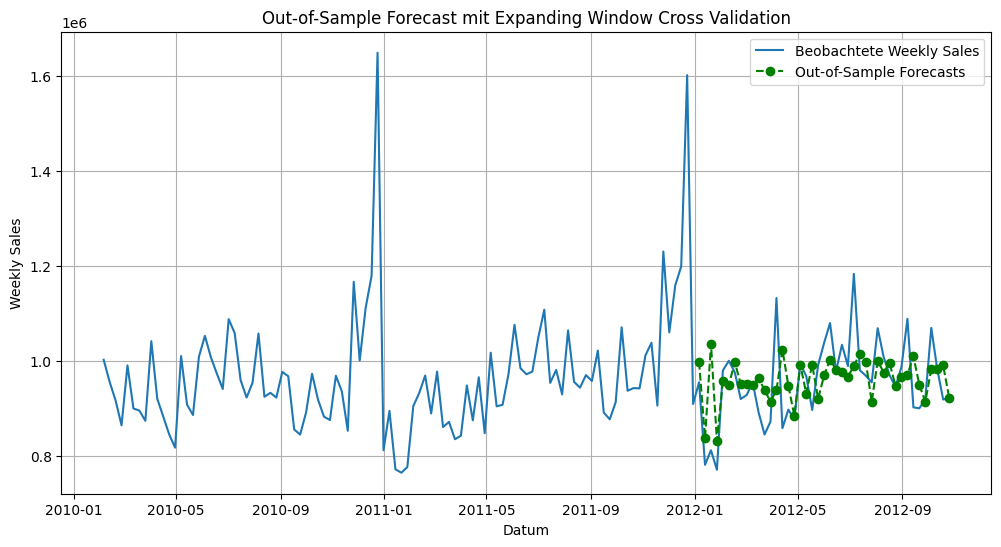

In [22]:
# Definiere den Anteil der Daten, der als initialer Trainingssatz verwendet wird (z.B. 70%)
train_size = int(len(sales) * 0.7)
test_data = sales[train_size:]
print(f"Trainingsgröße: {train_size}, Testgröße: {len(sales)-train_size}")

# Liste zur Speicherung der Ein-Schritt-Vorhersagen
oos_predictions = []

# Kopie des Trainingsdatensatzes für das Expanding Window
history = sales[:train_size].copy()

# Out-of-Sample Prognose: Für jeden Zeitschritt im Testabschnitt
for t in range(len(test_data)):
    # Modell an den aktuellen Trainingsdaten schätzen
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    # Eine Ein-Schritt-Prognose erstellen
    yhat = model_fit.forecast(steps=1)
    oos_predictions.append(yhat.iloc[0])
    # Füge den tatsächlichen Wert des Testabschnitts zu den Trainingsdaten hinzu
    history = pd.concat([history, test_data.iloc[[t]]])

# Berechne den Fehler (z.B. Mean Squared Error) für die Out-of-Sample Prognosen
error = test_data - oos_predictions
mse = np.mean(np.square(error))
print("Mean Squared Error (Out-of-Sample):", mse)

# Berechne RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (Out-of-Sample):", rmse)

# Berechne den Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test_data - oos_predictions) / test_data)) * 100
print("Mean Absolute Percentage Error (Out-of-Sample):", mape, "%")

# Plot: Gesamtdaten mit Out-of-Sample Prognosen
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachtete Weekly Sales')
plt.plot(test_data.index, oos_predictions, label='Out-of-Sample Forecasts', marker='o', linestyle='--', color='green')
plt.title('Out-of-Sample Forecast mit Expanding Window Cross Validation')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Festlegen des Anfangsbereichs für das Training (z.B. 70 % der Daten)
train_size = int(len(sales) * 0.7)
cv_results = []  # Liste, um Prognosen und Fehler zu speichern

# Expanding Window Cross-Validation
for i in range(train_size, len(sales)):
    train_data = sales.iloc[:i]         # Trainingsdaten: von Anfang bis zum aktuellen Zeitpunkt
    test_data = sales.iloc[i:i+1]         # Testdaten: der nächste Zeitpunkt
    
    try:
        # Fit des ARIMA-Modells mit dem bereits ermittelten optimalen Order
        model_cv = ARIMA(train_data, order=best_order)
        model_fit_cv = model_cv.fit()
        
        # One-Step Forecast
        forecast = model_fit_cv.forecast(steps=1)
        
        # Berechne den Fehler: tatsächlicher Wert - Prognose
        error = test_data.iloc[0] - forecast.iloc[0]
        
        cv_results.append({
            'date': sales.index[i],
            'actual': test_data.iloc[0],
            'forecast': forecast.iloc[0],
            'error': error
        })
        
    except Exception as e:
        print(f"Fehler bei Index {i}: {e}")
        continue

# Ergebnisse in ein DataFrame umwandeln
cv_df = pd.DataFrame(cv_results)

# Metriken zur Bewertung, z.B. RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(cv_df['actual'], cv_df['forecast']))
print("Cross-Validation RMSE:", rmse)



Cross-Validation RMSE: 78680.62680083192


Plotten

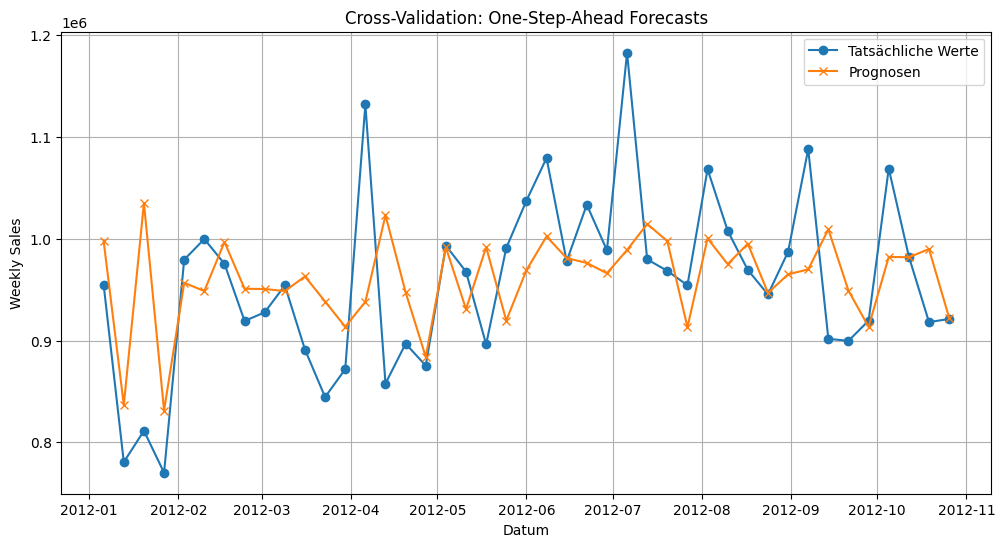

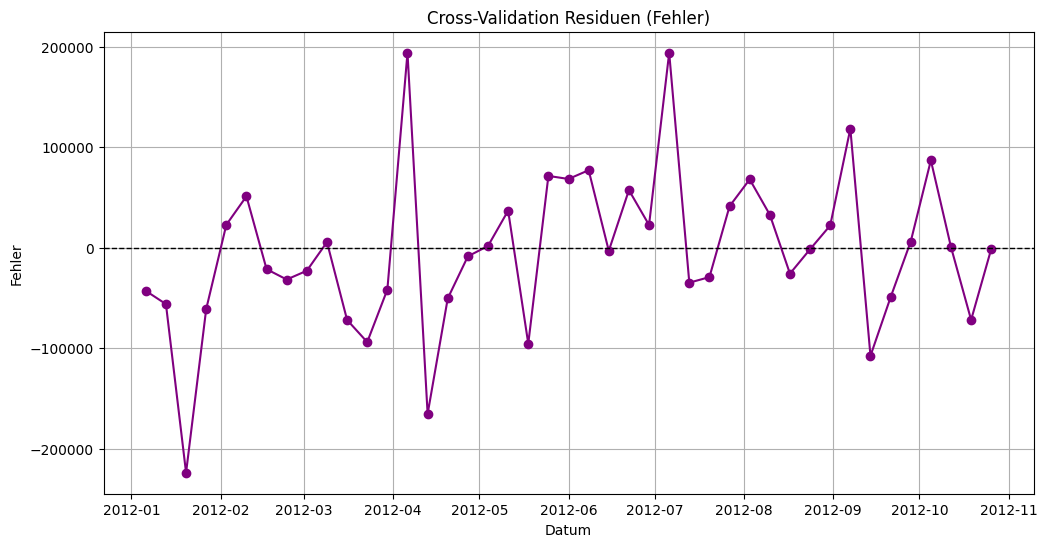

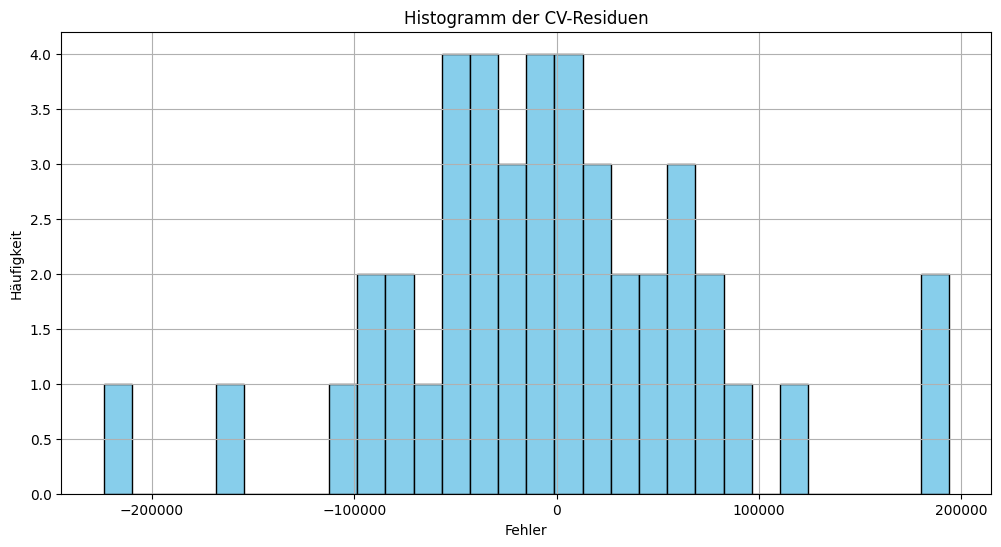

In [24]:
# Plot der Forecasts vs. tatsächliche Werte
plt.figure(figsize=(12, 6))
plt.plot(sales.index[train_size:], cv_df['actual'], label='Tatsächliche Werte', marker='o')
plt.plot(sales.index[train_size:], cv_df['forecast'], label='Prognosen', marker='x')
plt.title('Cross-Validation: One-Step-Ahead Forecasts')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

# Plot des Fehlerverlaufs (Residuals der CV)
plt.figure(figsize=(12, 6))
plt.plot(cv_df['date'], cv_df['error'], marker='o', linestyle='-', color='purple')
plt.title('Cross-Validation Residuen (Fehler)')
plt.xlabel('Datum')
plt.ylabel('Fehler')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Histogramm der Fehler aus der Cross-Validation
plt.figure(figsize=(12, 6))
plt.hist(cv_df['error'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der CV-Residuen')
plt.xlabel('Fehler')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()


Residuen Box-Plot

Store mit dem kleinsten Residuen-Mittelwert: Store 36 mit -3605.78
Store mit dem größten Residuen-Mittelwert: Store 38 mit 3572.61


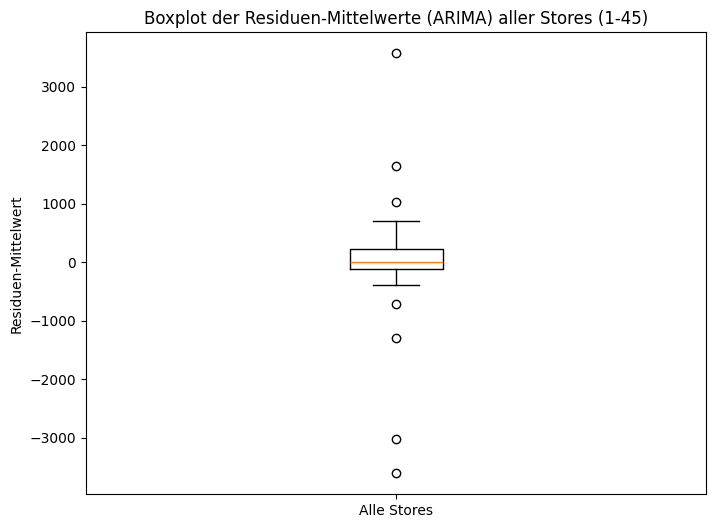

In [25]:

# Liste zur Speicherung der (Store, Residuen-Mittelwert)-Paare
store_resid_means = []

# Für jeden Store (1 bis 45)
for store in range(1, 46):
    store_data = df[df['Store'] == store].copy()
    store_data.sort_values('Date', inplace=True)
    store_data.set_index('Date', inplace=True)
    sales = store_data['Weekly_Sales']
    
    try:
        # ARIMA-Modell anpassen; hier als Beispiel ARIMA(2,0,2)
        model = ARIMA(sales, order=(2, 0, 2))
        model_fit = model.fit()
        
        # Fitted Values extrahieren
        fitted_values = model_fit.fittedvalues
        
        # Residuen berechnen
        residuals_arima = sales - fitted_values
        
        # Mittelwert der Residuen berechnen (NaN-Werte ignorieren)
        mean_resid = residuals_arima.mean()
        store_resid_means.append((store, mean_resid))
    except Exception as e:
        store_resid_means.append((store, float('nan')))
        print(f"Fehler bei Store {store}: {e}")

# Extrahiere nur gültige Werte (ohne NaN)
valid_resid_means = [(store, mean) for store, mean in store_resid_means if pd.notnull(mean)]

# Finde den Store mit dem kleinsten und den mit dem größten Residuen-Mittelwert
if valid_resid_means:
    store_min, min_val = min(valid_resid_means, key=lambda x: x[1])
    store_max, max_val = max(valid_resid_means, key=lambda x: x[1])
    
    print(f"Store mit dem kleinsten Residuen-Mittelwert: Store {store_min} mit {min_val:.2f}")
    print(f"Store mit dem größten Residuen-Mittelwert: Store {store_max} mit {max_val:.2f}")
else:
    print("Keine gültigen Residuen-Mittelwerte vorhanden.")

# Erstelle einen Boxplot der Residuen-Mittelwerte aller Stores
# Extrahiere nur die Mittelwerte aus valid_resid_means
resid_means = [mean for store, mean in valid_resid_means]

plt.figure(figsize=(8, 6))
plt.boxplot(resid_means)
plt.title("Boxplot der Residuen-Mittelwerte (ARIMA) aller Stores (1-45)")
plt.ylabel("Residuen-Mittelwert")
plt.xticks([1], ["Alle Stores"])
plt.show()

